In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
taxi_small = pd.read_csv("taxi-reduced-8434").drop('Unnamed: 0',axis = 1)
taxi_med = pd.read_csv("taxi-reduced-84394").drop('Unnamed: 0',axis = 1)
taxi_large = pd.read_csv("taxi-reduced-843984").drop('Unnamed: 0',axis = 1)

# Exploratory Data Analysis

### Trip distance/ fare amount analysis

In [3]:
print('min fare:', taxi_large['fare_amount'].min())
print('max fare:', taxi_large['fare_amount'].max())

min fare: -200.0
max fare: 545.5


Possible issue with having negative fare amounts. Something to look into. Maybe these are bad records.

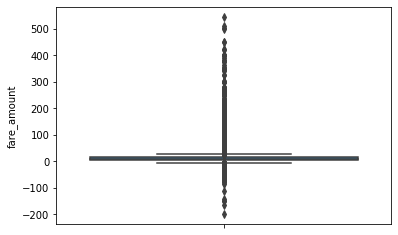

In [4]:
sns.boxplot(y=taxi_large['fare_amount'])

Lots of outliers in terms of fare amount

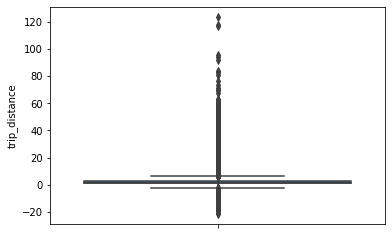

In [5]:
sns.boxplot(y = taxi_large['trip_distance'])

In [6]:
len(taxi_large[taxi_large['trip_distance'] > 40].index)

111

Only 111 instances where the trip was more than 40 miles

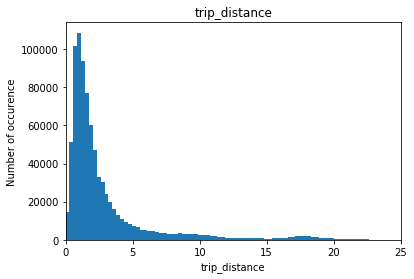

In [7]:
plt.hist(taxi_large.trip_distance, 500)
plt.title('trip_distance')
plt.xlabel('trip_distance')
plt.ylabel('Number of occurence')
plt.xlim(0, 25)
plt.show();

Most trips are less than 1.5 miles which means fares will be impacted by traffic conditions since they mostly originate within the city

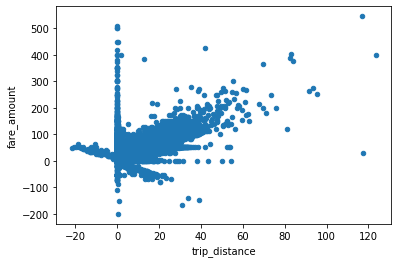

In [9]:
taxi_large.plot.scatter(x='trip_distance', y='fare_amount')

In [10]:
taxi_large[taxi_large['trip_distance'] <1]['fare_amount'].describe()

count    215172.000000
mean          6.444865
std           8.922533
min        -200.000000
25%           4.500000
50%           5.500000
75%           6.500000
max         509.500000
Name: fare_amount, dtype: float64

Inconsistencies beween distance and fares; negative fares, expensive short rides

In [11]:
taxi_large['fare_per_mile'] = taxi_large['fare_amount']/taxi_large['trip_distance']
print('The 99th percentile of fare/mile:',taxi_large['fare_per_mile'].quantile(0.99))

The 99th percentile of fare/mile: 86.66666666666667


In [12]:
fare_stats = taxi_large[(taxi_large["fare_amount"]>0) & (taxi_large["trip_distance"]>0)]["fare_per_mile"].dropna().describe()
fare_stats

count    835018.000000
mean          8.052390
std          88.418844
min           0.000185
25%           4.315555
50%           5.508475
75%           7.051282
max       18700.000000
Name: fare_per_mile, dtype: float64

In [13]:
# calculate interquartile range
iqr = fare_stats["75%"] - fare_stats["25%"]

In [14]:
# determine outliers
outlier_cutoff = fare_stats["50%"] + 3*iqr

## Determine distribution of fares

In [15]:
# Determine distribution of fares
print(taxi_large.groupby('fare_amount').size().nlargest(20))

fare_amount
6.0     41265
6.5     40816
7.0     40073
5.5     39821
7.5     38363
5.0     36858
8.0     36687
8.5     34207
9.0     32078
4.5     29938
9.5     29571
10.0    27932
10.5    25657
11.0    23225
52.0    22534
11.5    21048
4.0     20882
12.0    19598
12.5    17555
13.0    16156
dtype: int64


\\$52 is the fixed fare for airport, and most fares are between \\$6-\\$13, which means most rides are within Manhattan

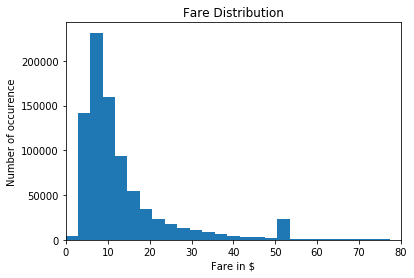

In [16]:
## Bin and plot histogram (for fares)

plt.hist(taxi_large.fare_amount, 250)
plt.title('Fare Distribution')
plt.xlabel('Fare in $')
plt.ylabel('Number of occurence')
plt.xlim(0, 80)
plt.show();

## Pickup and Dropoff location analysis

In [17]:
#read in key for taxi zones
taxi_zones = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv")

#display zones for visual aid
taxi_zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [18]:
taxi_zones["Zone"].value_counts()

Governor's Island/Ellis Island/Liberty Island    3
Corona                                           2
Flatbush/Ditmas Park                             1
East Tremont                                     1
Auburndale                                       1
                                                ..
Midtown South                                    1
Jamaica                                          1
Cobble Hill                                      1
Battery Park City                                1
Steinway                                         1
Name: Zone, Length: 261, dtype: int64

In [19]:
## Determine distribution of PULocationID and DOLocationID

# Top 5 pickup zone and borough
pu = pd.DataFrame(taxi_large.groupby('PULocationID').size().nlargest(5))
print('\nTop 5 pickup borough and zone\n',pu.join(other = taxi_zones.set_index("LocationID"), on = "PULocationID", how = "left"))


Top 5 pickup borough and zone
                   0    Borough                          Zone service_zone
PULocationID                                                             
237           36426  Manhattan         Upper East Side South  Yellow Zone
161           34323  Manhattan                Midtown Center  Yellow Zone
236           32995  Manhattan         Upper East Side North  Yellow Zone
186           30527  Manhattan  Penn Station/Madison Sq West  Yellow Zone
162           30441  Manhattan                  Midtown East  Yellow Zone


In [20]:
# Top 5 dropoff zone and borough
do = pd.DataFrame(taxi_large.groupby('DOLocationID').size().nlargest(5))
print('\nTop 5 dropoff borough and zone\n',do.join(other = taxi_zones.set_index("LocationID"), on = "DOLocationID", how = "left"))


Top 5 dropoff borough and zone
                   0    Borough                       Zone service_zone
DOLocationID                                                          
236           34281  Manhattan      Upper East Side North  Yellow Zone
161           32889  Manhattan             Midtown Center  Yellow Zone
237           32419  Manhattan      Upper East Side South  Yellow Zone
170           26449  Manhattan                Murray Hill  Yellow Zone
230           26136  Manhattan  Times Sq/Theatre District  Yellow Zone


Most pickups and dropoffs are within Manhattan

In [21]:
## Determine distribution of trip distance and passengers

print(taxi_large.groupby('trip_distance').size().nlargest(10),'\n')
print(taxi_large.groupby('passenger_count').size().nlargest(10),'\n')

trip_distance
0.8    16358
0.9    16345
1.0    16120
0.7    15422
1.1    15367
1.2    14675
0.6    13906
1.3    13444
1.4    12609
1.5    11853
dtype: int64 

passenger_count
1.0    590647
2.0    128271
3.0     35610
5.0     34155
6.0     20369
4.0     17296
0.0     15337
8.0         5
7.0         4
9.0         3
dtype: int64 



/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


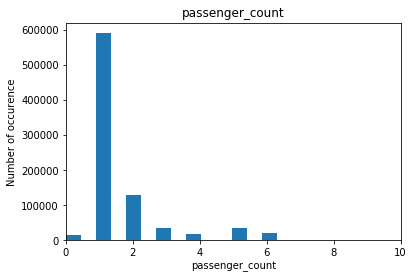

In [22]:
plt.hist(taxi_large.passenger_count, 20)
plt.title('passenger_count')
plt.xlabel('passenger_count')
plt.ylabel('Number of occurence')
plt.xlim(0, 10)
plt.show();

Most trips are with 0-6 passengers, 0 because passenger information is reported by drivers and they might have missed it

## Location vs Cost analysis

In [23]:
#which pickup locations end up with the highest and lowest average cost
loc_cost_group = taxi_large.groupby('PULocationID').mean()['fare_amount']
loc_cost_group = loc_cost_group.sort_values()

print('Highest Average Cost:')
max_id = loc_cost_group.index[-1]
max_borough = taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,1]
max_zone= taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,2]
print('\t Zone:', max_zone)
print('\t Borough:', max_borough)
print('\t Cost:',loc_cost_group.max() )
print()

print('Lowest Average Cost:')
min_id = loc_cost_group.index[0]
min_borough = taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,1]
min_zone= taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,2]
print('\t Zone:', min_zone)
print('\t Borough:',min_borough)
print('\t Cost:',loc_cost_group.min())

Highest Average Cost:
	 Zone: West Brighton
	 Borough: Staten Island
	 Cost: 104.0

Lowest Average Cost:
	 Zone: Eltingville/Annadale/Prince's Bay
	 Borough: Staten Island
	 Cost: 0.0


In [24]:
#compare to drop off location.
#see if values are different
#which drop off locations have the highest and lowest average cost
loc_cost_group = taxi_large.groupby('DOLocationID').mean()['fare_amount']
loc_cost_group = loc_cost_group.sort_values()

print('Highest Average Cost:')
max_id = loc_cost_group.index[-1]
max_borough = taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,1]
max_zone= taxi_zones[ taxi_zones['LocationID'] == max_id ].iloc[0,2]
print('\t Zone:', max_zone)
print('\t Borough:', max_borough)
print('\t Cost:',loc_cost_group.max() )
print()

print('Lowest Average Cost:')
min_id = loc_cost_group.index[0]
min_borough = taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,1]
min_zone= taxi_zones[ taxi_zones['LocationID'] == min_id ].iloc[0,2]
print('\t Zone:', min_zone)
print('\t Borough:',min_borough)
print('\t Cost:',loc_cost_group.min())


Highest Average Cost:
	 Zone: Rossville/Woodrow
	 Borough: Staten Island
	 Cost: 85.75

Lowest Average Cost:
	 Zone: Jamaica Bay
	 Borough: Queens
	 Cost: 3.1666666666666665


The "shape file" found here contains some information about the zones: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Somehow, uploading all of them to this site out puts a csv with latitudes and longitudes 

https://mygeodata.cloud/

In [25]:
zones_latlong = pd.read_csv("taxi_zones.csv")

In [26]:
zones_latlong.head()

,X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,-74.176786,40.689516,1,0.116357,0.000782,Newark Airport,1,EWR
1,-73.826126,40.625724,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,-73.849479,40.865888,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,-74.189930,40.550340,5,0.092146,0.000498,Arden Heights,5,Staten Island


Join the lat/ long for each zone, dropping unneccessary columns 

In [63]:
lat_long_fare = taxi_large.join(other = zones_latlong.set_index("LocationID")[["X","Y"]], on = "PULocationID", how ="left")[["X","Y","fare_amount"]]
lat_long_fare.rename({"X":"Longitude", "Y": "Latitude"}, axis = 1, inplace = True)
lat_long_fare

,Longitude,Latitude,fare_amount
0,-73.903713,40.746798,6.5
1,-73.954568,40.765507,7.0
2,-73.972145,40.756816,14.5
3,-73.956972,40.780491,5.5
4,-74.007176,40.725376,7.5
...,...,...,...
843979,-73.992455,40.748476,15.0
843980,-73.990478,40.740313,12.5
843981,-73.989857,40.762237,21.0
843982,-73.984176,40.759845,6.0


In [102]:
import numpy as np

PU_zone_group = taxi_large.groupby('PULocationID').mean()['fare_amount']
PU_fare = zones_latlong.copy()
PU_fare =PU_fare.drop(['OBJECTID', 'Shape_Leng','Shape_Area','zone','LocationID','borough'], axis = 1)
PU_fare['avg_fare'] = taxi_large.groupby('PULocationID').mean()['fare_amount']

PU_fare['avg_fare'] = PU_fare['avg_fare'].fillna(0)

lats = PU_fare['Y'].to_numpy()
longs = PU_fare['X'].to_numpy()
locations = PU_fare[['X','Y']]
fare_vals = PU_fare['avg_fare']



In [104]:
'''from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(width=600000,height=500000,projection='lcc',
            resolution='l', lat_0=40.730610,lon_0= -73.935242)
m.pcolormesh(longs, lats , fare_vals,
             latlon=True, cmap='RdBu_r')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.shadedrelief()
plt.show()'''

"from mpl_toolkits.basemap import Basemap\nimport matplotlib.pyplot as plt\n# setup Lambert Conformal basemap.\n# set resolution=None to skip processing of boundary datasets.\nm = Basemap(width=600000,height=500000,projection='lcc',\n            resolution='l', lat_0=40.730610,lon_0= -73.935242)\nm.pcolormesh(longs, lats , fare_vals,\n             latlon=True, cmap='RdBu_r')\nm.drawcoastlines()\nm.drawcountries()\nm.drawstates()\nm.shadedrelief()\nplt.show()"

Make a dataframe that includes pickup and dropoff longitude and latitude

In [59]:
# make a couple of data frames for pick up and dropooff location
PU_lat_long = taxi_large.join(other = zones_latlong.set_index("LocationID")[["X","Y"]], on = "PULocationID", how ="left")[["X","Y"]]
PU_lat_long.rename({"X":"Pickup_Latitude", "Y": "Pickup_Longitude"}, axis = 1, inplace = True)
DO_lat_long = taxi_large.join(other = zones_latlong.set_index("LocationID")[["X","Y"]], on = "DOLocationID", how ="left")[["X","Y"]]
DO_lat_long.rename({"X":"Dropoff_Latitude", "Y": "Dropoff_Longitude"}, axis = 1, inplace = True)

In [60]:
# join the dataframes
PU_DO_lat_long = PU_lat_long.join(other = DO_lat_long, how = "inner")
PU_DO_lat_long.head()

,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude
0,-73.903713,40.746798,-73.929321,40.735273
1,-73.954568,40.765507,-73.965691,40.768542
2,-73.972145,40.756816,-73.965572,40.782460
3,-73.956972,40.780491,-73.944957,40.790650
4,-74.007176,40.725376,-73.994628,40.732486


In [61]:
# calculate traveled latitude and longitude
PU_DO_lat_long["Latitude Traveled"] = abs(PU_DO_lat_long["Pickup_Latitude"] - PU_DO_lat_long["Dropoff_Latitude"])
PU_DO_lat_long["Longitude Traveled"] = abs(PU_DO_lat_long["Pickup_Longitude"] - PU_DO_lat_long["Dropoff_Longitude"])
PU_DO_lat_long.head()

,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Latitude Traveled,Longitude Traveled
0,-73.903713,40.746798,-73.929321,40.735273,0.025608,0.011524
1,-73.954568,40.765507,-73.965691,40.768542,0.011123,0.003035
2,-73.972145,40.756816,-73.965572,40.782460,0.006573,0.025644
3,-73.956972,40.780491,-73.944957,40.790650,0.012016,0.010159
4,-74.007176,40.725376,-73.994628,40.732486,0.012547,0.007110


Determine Boundary

In [62]:
print("Longitude Boundary in reduced data")
min_long = min(PU_DO_lat_long['Pickup_Longitude'].min(), PU_DO_lat_long['Dropoff_Longitude'].min())
max_long = max(PU_DO_lat_long['Pickup_Longitude'].max(), PU_DO_lat_long['Dropoff_Longitude'].max())
print('Min:',min_long,', Max:',max_long)

print("\nLatitude Boundary in reduced data")
min_lat = min(PU_DO_lat_long['Pickup_Latitude'].min(), PU_DO_lat_long['Dropoff_Latitude'].min())
max_lat = max(PU_DO_lat_long['Pickup_Latitude'].max(), PU_DO_lat_long['Dropoff_Latitude'].max())
print('Min:',min_lat,', Max:',max_lat)

Longitude Boundary in reduced data
Min: 40.527298175003 , Max: 40.899859621114295

Latitude Boundary in reduced data
Min: -74.2295465457844 , Max: -73.7090705910379


Add pickup and dropoff zone and borough information to taxi_large

In [66]:
df2 = taxi_large.join(other = taxi_zones.set_index("LocationID"), on = "PULocationID", how = "left")
df2 = df2.rename(columns={"Borough": "PU_Borough","Zone": "PU_Zone", "service_zone": "PU_service_zone"})
df3 = df2.join(other = taxi_zones.set_index("LocationID"), on = "DOLocationID", how = "left")
df3 = df3.rename(columns={"Borough": "DO_Borough","Zone": "DO_Zone", "service_zone": "DO_service_zone"})
df3.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,spring,summer,fall,fare_per_mile,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone
0,1.0,2019-01-12 11:22:29,2019-01-12 11:29:48,2.0,0.90,1.0,N,260,226,2.0,...,0,0,0,7.222222,Queens,Woodside,Boro Zone,Queens,Sunnyside,Boro Zone
1,2.0,2019-01-10 18:49:12,2019-01-10 18:57:21,1.0,1.01,1.0,N,140,237,1.0,...,0,0,0,6.930693,Manhattan,Lenox Hill East,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone
2,2.0,2019-01-29 12:55:07,2019-01-29 13:15:27,1.0,2.64,1.0,N,162,43,2.0,...,0,0,0,5.492424,Manhattan,Midtown East,Yellow Zone,Manhattan,Central Park,Yellow Zone
3,1.0,2019-01-11 18:07:20,2019-01-11 18:11:42,1.0,1.00,1.0,N,236,75,1.0,...,0,0,0,5.500000,Manhattan,Upper East Side North,Yellow Zone,Manhattan,East Harlem South,Boro Zone
4,2.0,2019-01-18 09:06:26,2019-01-18 09:16:14,1.0,1.59,1.0,N,125,113,2.0,...,0,0,0,4.716981,Manhattan,Hudson Sq,Yellow Zone,Manhattan,Greenwich Village North,Yellow Zone


In [67]:
# separate the date and time into separate columns
df3['pickup_datetime'] = pd.to_datetime(df3['tpep_pickup_datetime'])
df3['dropoff_datetime'] = pd.to_datetime(df3['tpep_dropoff_datetime'])

# make a new dataframe with fares
df4 = df3[['pickup_datetime','dropoff_datetime','fare_amount','PULocationID','PU_Zone','DOLocationID','DO_Zone','trip_distance']].copy()
df4['ride_duration'] = np.vectorize(lambda drop, pick: drop - pick)(df3['dropoff_datetime'], df3['pickup_datetime'])

# Convert ride duration to minutes
df4['ride_duration_hours'] = list(map(lambda dur: dur.seconds/3600, df4['ride_duration']))

# Calculate average Speed
df4['average_speed_mph'] = df4['trip_distance']/df4['ride_duration_hours']
df4.head()

,pickup_datetime,dropoff_datetime,fare_amount,PULocationID,PU_Zone,DOLocationID,DO_Zone,trip_distance,ride_duration,ride_duration_hours,average_speed_mph
0,2019-01-12 11:22:29,2019-01-12 11:29:48,6.5,260,Woodside,226,Sunnyside,0.90,00:07:19,0.121944,7.380410
1,2019-01-10 18:49:12,2019-01-10 18:57:21,7.0,140,Lenox Hill East,237,Upper East Side South,1.01,00:08:09,0.135833,7.435583
2,2019-01-29 12:55:07,2019-01-29 13:15:27,14.5,162,Midtown East,43,Central Park,2.64,00:20:20,0.338889,7.790164
3,2019-01-11 18:07:20,2019-01-11 18:11:42,5.5,236,Upper East Side North,75,East Harlem South,1.00,00:04:22,0.072778,13.740458
4,2019-01-18 09:06:26,2019-01-18 09:16:14,7.5,125,Hudson Sq,113,Greenwich Village North,1.59,00:09:48,0.163333,9.734694


This pivot table will have latitude on the Y axis and longitude on the X axis

In [69]:
pivot = lat_long_fare.pivot_table(values = "fare_amount", index = "Latitude", columns = "Longitude")
pivot

Longitude,40.527298,40.532017,40.550340,40.558950,40.576900,40.577469,40.579618,40.580262,40.582196,40.585631,...,40.874062,40.875600,40.875976,40.876853,40.877359,40.881901,40.883223,40.894746,40.899103,40.899860
Latitude,,,,,,,,,,,,,,,,,,,,,
-74.229547,22.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-74.189930,NaN,NaN,64.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-74.187703,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-74.176786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-74.173937,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-73.736719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-73.735550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-73.731392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a ton of Null values because some of the latitudes and longitude pairs are not valid pickup locations, so no one has ever been picked up there. Fill them with zeroes

In [70]:
pivot.fillna(0, inplace = True)

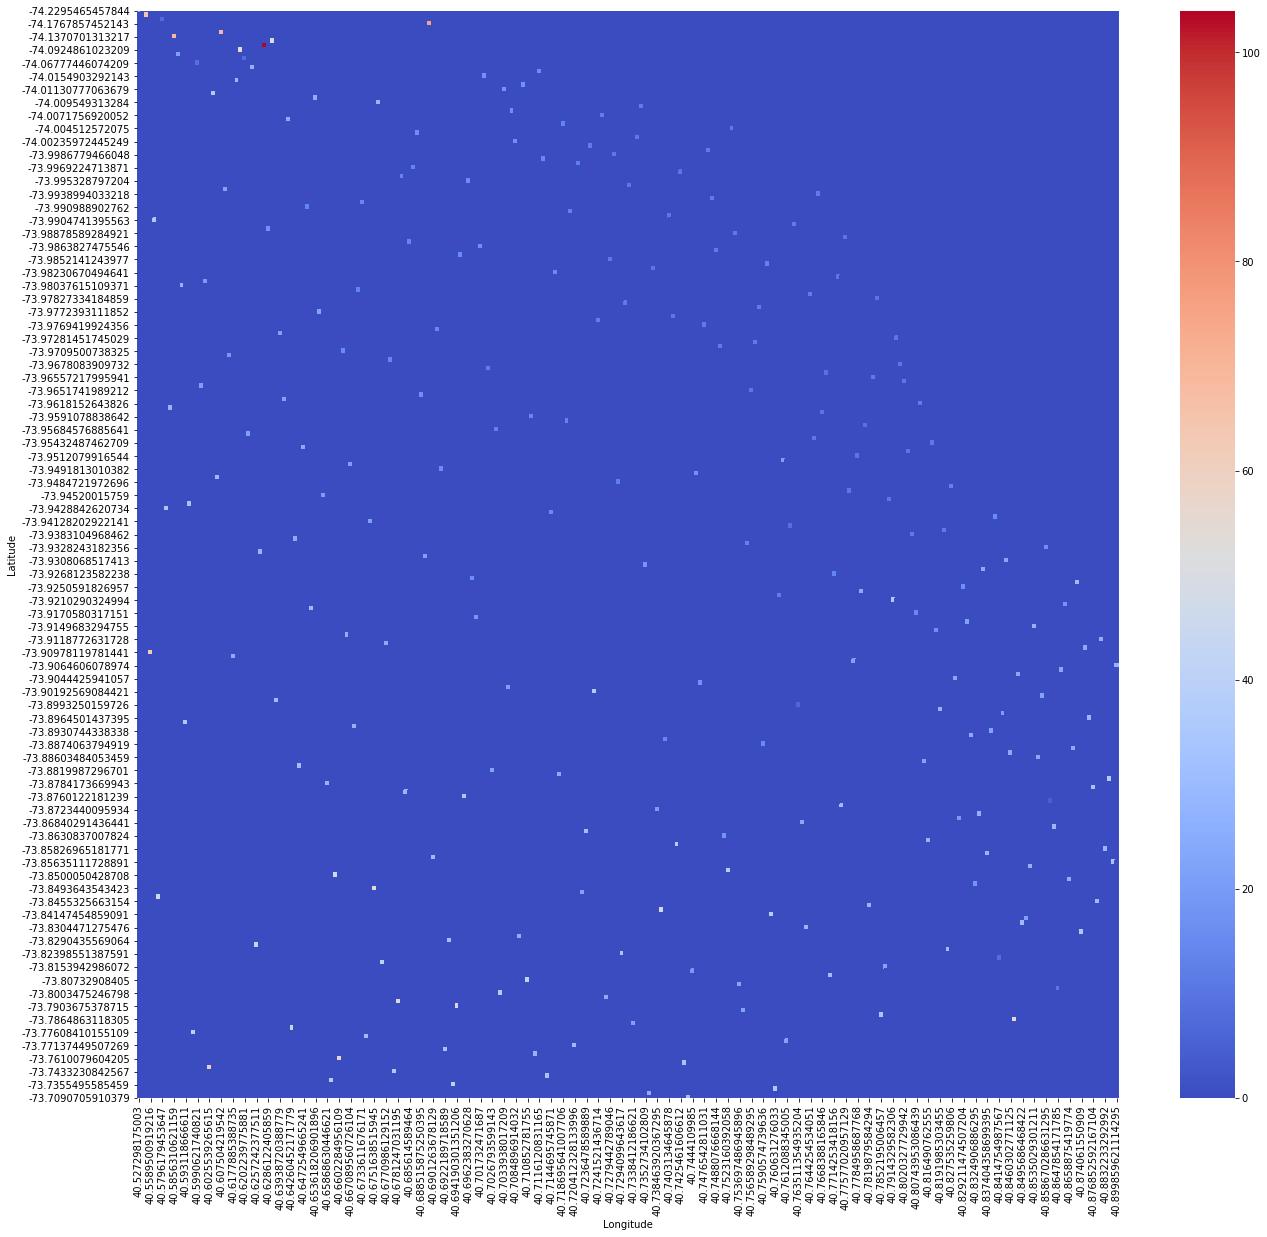

In [71]:
plt.figure(figsize=(22,20))
sns.heatmap(pivot, cmap="coolwarm")

Look at average fare at each pickup latitude

In [72]:
lat_fare = lat_long_fare.groupby("Latitude").mean()["fare_amount"]
lat_fare.head()

Latitude
-74.229547    22.125000
-74.189930    64.583333
-74.187703     8.000000
-74.176786    75.466778
-74.173937     0.000000
Name: fare_amount, dtype: float64

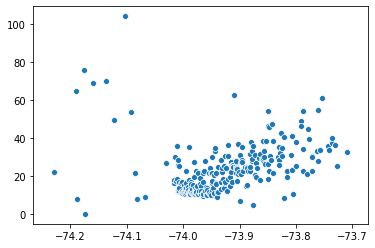

In [73]:
sns.scatterplot(data = lat_fare)

Fit a linear regression to fare and latitude and plot the resulting line

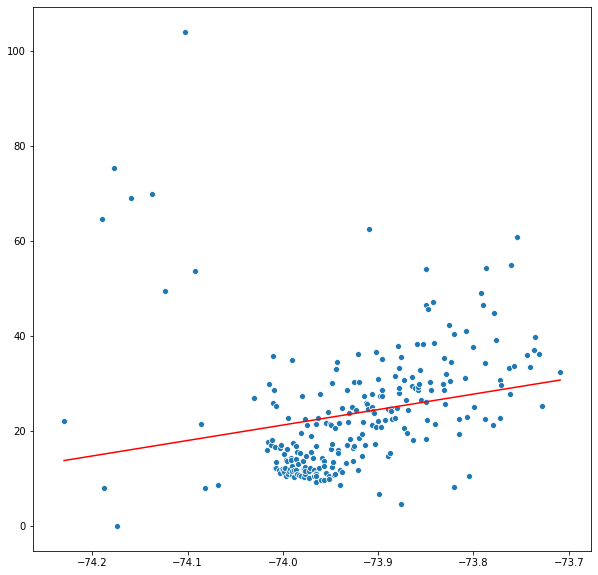

In [74]:
lf = pd.DataFrame(lat_fare).reset_index()

import numpy as np
X_lat = np.array(lf['Latitude']).reshape(-1, 1)
y_lat = np.array(lf['fare_amount']).reshape(-1, 1)

from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_lat, y_lat)

X_plot = np.linspace(X_lat.min(), X_lat.max(), 100)
Y_plot = lm.coef_*X_plot+lm.intercept_
plt.figure(figsize = (10,10))
sns.scatterplot(data = lat_fare)
plt.plot(X_plot,Y_plot[0], color = "red")

Looks like there is a weak positive correlation between latitude and fare

Do the same thing for longitude

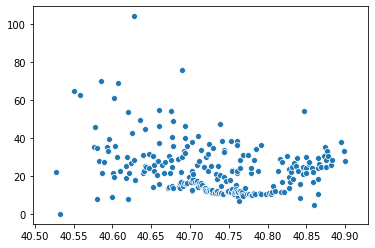

In [75]:
long_fare = lat_long_fare.groupby("Longitude").mean()["fare_amount"]
sns.scatterplot(data = long_fare)

Looks like there is a weak negative correlation between Longitude and fare

Fit another regression

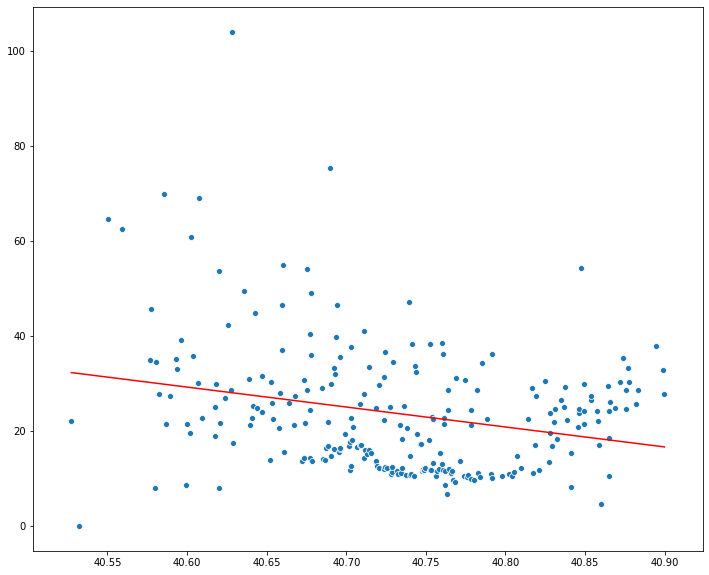

In [76]:
lf2 = pd.DataFrame(long_fare).reset_index()

X_lon = np.array(lf2['Longitude']).reshape(-1, 1)
y_lon = np.array(lf2['fare_amount']).reshape(-1, 1)

lm2 = LinearRegression().fit(X_lon, y_lon)

X_plot2 = np.linspace(X_lon.min(), X_lon.max(), 2)
Y_plot2 = lm2.coef_*X_plot2+lm2.intercept_
plt.figure(figsize = (12,10))
sns.scatterplot(data = long_fare)
plt.plot(X_plot2,Y_plot2[0], color = "red")

## Fare by time/ date/ season Analysis

Look at average fare and number of records in each season

In [139]:
winter = taxi_large[taxi_large["winter"]==1]
spring = taxi_large[taxi_large["spring"]==1]
summer = taxi_large[taxi_large["summer"]==1]
fall = taxi_large[taxi_large["fall"]==1]

In [140]:
round(winter["fare_amount"].mean(),2)

12.72

In [141]:
len(winter.index)

215833

In [142]:
round(spring["fare_amount"].mean(),2)

13.17

In [143]:
len(spring)

228308

In [144]:
round(summer["fare_amount"].mean(),2)

13.64

In [145]:
round(fall["fare_amount"].mean(),2)

13.59

In [146]:
len(fall.index)

206596

Identify date/time outliers

In [92]:
# separate the date and time into separate columns
taxi_large['pickup_datetime'] = pd.to_datetime(taxi_large['tpep_pickup_datetime'])
taxi_large['dropoff_datetime'] = pd.to_datetime(taxi_large['tpep_dropoff_datetime'])
taxi_large.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,winter,spring,summer,fall,fare_per_mile,pickup_datetime,dropoff_datetime
0,1.0,2019-01-12 11:22:29,2019-01-12 11:29:48,2.0,0.90,1.0,N,260,226,2.0,...,0.3,7.30,NaN,1,0,0,0,7.222222,2019-01-12 11:22:29,2019-01-12 11:29:48
1,2.0,2019-01-10 18:49:12,2019-01-10 18:57:21,1.0,1.01,1.0,N,140,237,1.0,...,0.3,10.56,NaN,1,0,0,0,6.930693,2019-01-10 18:49:12,2019-01-10 18:57:21
2,2.0,2019-01-29 12:55:07,2019-01-29 13:15:27,1.0,2.64,1.0,N,162,43,2.0,...,0.3,15.30,0.0,1,0,0,0,5.492424,2019-01-29 12:55:07,2019-01-29 13:15:27
3,1.0,2019-01-11 18:07:20,2019-01-11 18:11:42,1.0,1.00,1.0,N,236,75,1.0,...,0.3,8.03,NaN,1,0,0,0,5.500000,2019-01-11 18:07:20,2019-01-11 18:11:42
4,2.0,2019-01-18 09:06:26,2019-01-18 09:16:14,1.0,1.59,1.0,N,125,113,2.0,...,0.3,8.30,NaN,1,0,0,0,4.716981,2019-01-18 09:06:26,2019-01-18 09:16:14


In [94]:
# make a new dataframe with only dates, times, and fares
df = taxi_large[['pickup_datetime','dropoff_datetime','fare_amount']].copy()
df.head()

,pickup_datetime,dropoff_datetime,fare_amount
0,2019-01-12 11:22:29,2019-01-12 11:29:48,6.5
1,2019-01-10 18:49:12,2019-01-10 18:57:21,7.0
2,2019-01-29 12:55:07,2019-01-29 13:15:27,14.5
3,2019-01-11 18:07:20,2019-01-11 18:11:42,5.5
4,2019-01-18 09:06:26,2019-01-18 09:16:14,7.5


We can standardize the fare by dividing the average fare amount by the ride duration and map it to the time that the ride started. So, we'd be left with how much the average ride costs per minute for a given time. This would actually be better to determine if time has an impact on fare

In [96]:
# Sort dataframe by pickup times
# df = df.sort_values(by='pickup_datetime',ascending=True)
# Found that two entries aren't from 2019

from datetime import datetime, date, timedelta
import numpy as np

# Compute ride time
df['ride_duration'] = np.vectorize(lambda drop, pick: drop - pick)(df['dropoff_datetime'], df['pickup_datetime'])

# Drop rides longer than 3 hours
df.drop(df[df['ride_duration'] > timedelta(hours=3)].index, inplace=True)

# Drop rides less than 1 seconds
df.drop(df[df['ride_duration'] < timedelta(seconds=1)].index, inplace=True)

# Convert ride duration to minutes
df['ride_duration'] = list(map(lambda dur: dur.seconds/60, df['ride_duration']))

# Compute fare per minute
df['fare_per_min'] = df['fare_amount'] / df['ride_duration']


fares = [0.0] * 24
rides = [0.0] * 24
for _, row in df.iterrows():
    fares[row['pickup_datetime'].hour] += row['fare_per_min']
    rides[row['pickup_datetime'].hour] += 1
    
hourly_avg_fare_per_min = pd.DataFrame(columns=['average_fare_per_min'])
hourly_avg_fare_per_min['average_fare_per_min'] = list(map(lambda pair: pair[0]/pair[1], zip(fares, rides)))
hourly_avg_fare_per_min

,average_fare_per_min
0,4.227158
1,4.336790
2,5.156582
3,5.199971
4,5.810554
5,5.272447
6,3.476776
7,2.550354
8,2.335708
9,2.430958


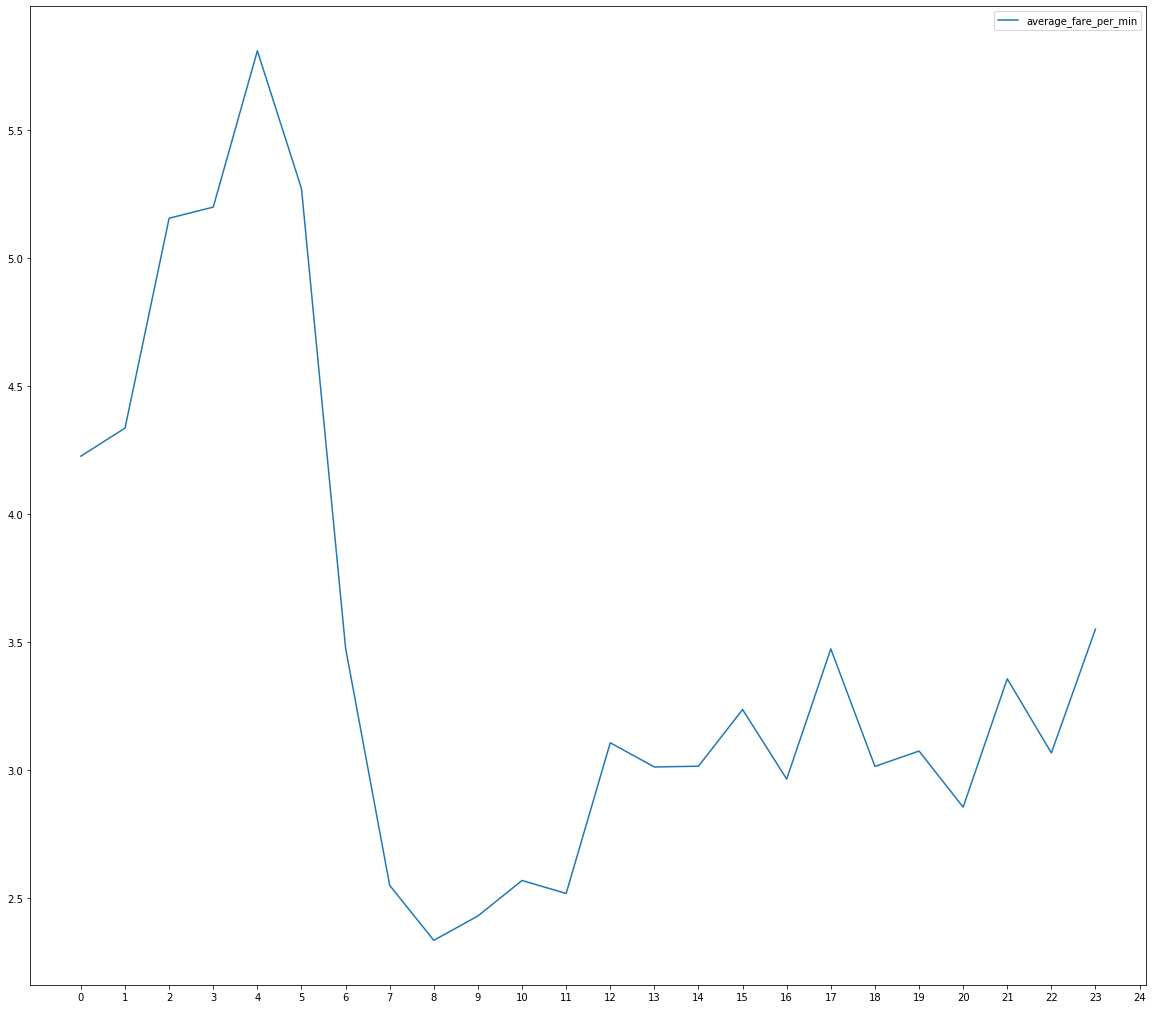

In [118]:
plt.figure(figsize = (20,18))
plt.xticks(list(range(0,25)))
sns.lineplot(data = hourly_avg_fare_per_min)

Issues found to be fixed:
-Two entries not from 2019
-Some entries that claim pick up and drop off at the same time, with passenger count of 0 and a huge fare (this doesn't mean that a 0 passenger count is always a huge fare, most of the time this is reasonable)
-Passenger count of 0 is very prevalent, cannot use passengers as a feature in the model
-Some rides are very long, but the fare is very cheap. If we are to use the length of the ride as feature, we would have to throw out the rides that are unusually long

## Anomaly Removal

In [173]:
## Make a cleaned version that has outliers removed

taxi_clean = taxi_large.copy()
# separate the date and time into separate columns
taxi_clean['pickup_datetime'] = pd.to_datetime(taxi_large['tpep_pickup_datetime'])
taxi_clean['dropoff_datetime'] = pd.to_datetime(taxi_large['tpep_dropoff_datetime'])

# Compute ride time
taxi_clean['ride_duration'] = np.vectorize(lambda drop, pick: drop - pick)(taxi_clean['dropoff_datetime'], 
                                                                           taxi_clean['pickup_datetime'])

# Drop rides longer than 3 hours
taxi_clean.drop(taxi_clean[taxi_clean['ride_duration'] > timedelta(hours=3)].index, inplace=True)

# Drop rides less than 1 seconds
taxi_clean.drop(taxi_clean[taxi_clean['ride_duration'] < timedelta(seconds=1)].index, inplace=True)

 # drop rides with negative distances
taxi_clean.drop(taxi_clean[taxi_clean["trip_distance"] <= 0 ].index, inplace = True)

# drop rides with negative fares
taxi_clean.drop(taxi_clean[taxi_clean["fare_amount"]<=2.5].index, inplace = True)

# drop rides that cost greater than $13/mile
taxi_clean.drop(taxi_clean[taxi_clean["fare_per_mile"]>13].index, inplace = True)
taxi_clean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Labor Day proximity,Veterans Day proximity,Thanksgiving Day proximity,Christmas Day proximity,St. Patricks proximity,UN Convenes proximity,UN Ajourns proximity,New Year's '18 proximity,Holiday Proximity,ride_duration
0,1.0,2019-01-12 11:22:29,2019-01-12 11:29:48,2.0,0.90,1.0,N,260,226,2.0,...,0,0,0,0,0,0,0,0,0,00:07:19
1,2.0,2019-01-10 18:49:12,2019-01-10 18:57:21,1.0,1.01,1.0,N,140,237,1.0,...,0,0,0,0,0,0,0,0,0,00:08:09
2,2.0,2019-01-29 12:55:07,2019-01-29 13:15:27,1.0,2.64,1.0,N,162,43,2.0,...,0,0,0,0,0,0,0,0,0,00:20:20
3,1.0,2019-01-11 18:07:20,2019-01-11 18:11:42,1.0,1.00,1.0,N,236,75,1.0,...,0,0,0,0,0,0,0,0,0,00:04:22
4,2.0,2019-01-18 09:06:26,2019-01-18 09:16:14,1.0,1.59,1.0,N,125,113,2.0,...,0,0,0,0,0,0,0,0,1,00:09:48


## Feature Engineering

Add dummies for time of day

In [176]:
taxi_clean["Early morning"] = taxi_large["pickup_datetime"].apply(lambda time: (int(time.hour < 5))) # before 5 am

In [177]:
taxi_clean["Morning"] = taxi_large["pickup_datetime"].apply(lambda time: (int(time.hour > 5 and time.hour < 12))) 
# after 5 am and before 12

In [178]:
taxi_clean["Afternoon"] = taxi_large["pickup_datetime"].apply(lambda time: (int(time.hour < 18 and time.hour > 12)))
# after 12 and before 6

In [179]:
taxi_clean["Night"] = taxi_large["pickup_datetime"].apply(lambda time: (int(time.hour > 21)))
# after 9

Analysis of mean fare within 24 hours of 12PM on a major holiday

https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020/data#

In [180]:
hol = pd.read_csv("usholidays.csv").drop("Unnamed: 0",1)

# only 10 unique holidays
hol_unique = hol.iloc[0:10]

hol = hol_unique
hol['month'], hol['day'] = hol["Date"].apply(lambda date: date.split('-')[1]),hol["Date"].apply(lambda date: date.split('-')[2])

hol['date'] = '2019-'+hol['month']+'-'+hol['day']+'-12:00'

hol.drop('Date',1,inplace = True)

hol['hol_date'] = pd.to_datetime(hol['date'])
hol.drop(['month','day','date'],1,inplace = True)
hol.drop([2,6], inplace = True)
hol.loc[10]=({"Holiday":"St. Patricks", "hol_date":pd.to_datetime('2019-3-19-12:00')})
hol.loc[11]=({"Holiday":"UN Convenes", "hol_date":pd.to_datetime('2019-9-23-12:00')})
hol.loc[12]=({"Holiday":"UN Ajourns", "hol_date":pd.to_datetime('2019-3-27-12:00')})
hol.loc[13]=({"Holiday":"New Year's '18", "hol_date":pd.to_datetime('2018-12-31-12:00')})
hol

,Holiday,hol_date
0,New Year's Day,2019-12-31 12:00:00
1,"Birthday of Martin Luther King, Jr.",2019-01-17 12:00:00
3,Memorial Day,2019-05-30 12:00:00
4,Independence Day,2019-07-04 12:00:00
5,Labor Day,2019-09-05 12:00:00
7,Veterans Day,2019-11-11 12:00:00
8,Thanksgiving Day,2019-11-24 12:00:00
9,Christmas Day,2019-12-26 12:00:00
10,St. Patricks,2019-03-19 12:00:00
11,UN Convenes,2019-09-23 12:00:00


In [181]:
# takes about 5 minutes to run this one
for ind in hol.index:
  hol_name = hol.loc[ind][0]
  hol_date = hol.loc[ind][1]
  print(hol_name+"\n")
  taxi_clean[hol_name+" proximity"] = taxi_clean["pickup_datetime"].apply(
      lambda ride_date:int((abs(ride_date-hol_date)<timedelta(days = 1))))

New Year's Day

Birthday of Martin Luther King, Jr.

Memorial Day

Independence Day

Labor Day

Veterans Day

Thanksgiving Day

Christmas Day

St. Patricks

UN Convenes

UN Ajourns

New Year's '18



In [182]:
holiday_prox = ["New Year's Day proximity",'Birthday of Martin Luther King, Jr. proximity','Memorial Day proximity', 
                'Independence Day proximity','Labor Day proximity', 'Veterans Day proximity','Thanksgiving Day proximity', 
                'Christmas Day proximity','St. Patricks proximity', 'UN Convenes proximity','UN Ajourns proximity',
               "New Year's '18 proximity"]
taxi_large["Holiday Proximity"] = taxi_clean[holiday_prox].apply(lambda ride_prox: int(sum(ride_prox)>0),1)

In [189]:
close_to_holiday = taxi_clean[taxi_clean["Holiday Proximity"]==1]

In [190]:
far_from_holiday = taxi_clean[taxi_clean["Holiday Proximity"]==0]

In [191]:
close_to_holiday["fare_amount"].mean()

13.360406053811658

In [192]:
far_from_holiday["fare_amount"].mean()

13.229079223886723

In [193]:
len(close_to_holiday.index)

44600

In [194]:
len(far_from_holiday.index)

768960

In [195]:
taxi_clean[taxi_clean["Thanksgiving Day proximity"]==1]['pickup_datetime'].min()

Timestamp('2019-11-23 12:00:14')

In [196]:
taxi_clean[taxi_clean["Thanksgiving Day proximity"]==1]['pickup_datetime'].max()

Timestamp('2019-11-25 11:59:59')

## Create Reduced versions of this dataframe

Drop unneccessary features

In [197]:
taxi_clean.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'winter', 'spring', 'summer',
       'fall', 'fare_per_mile', 'pickup_datetime', 'dropoff_datetime',
       'New Year's Day proximity',
       'Birthday of Martin Luther King, Jr. proximity',
       'Memorial Day proximity', 'Independence Day proximity',
       'Labor Day proximity', 'Veterans Day proximity',
       'Thanksgiving Day proximity', 'Christmas Day proximity',
       'St. Patricks proximity', 'UN Convenes proximity',
       'UN Ajourns proximity', 'New Year's '18 proximity', 'Holiday Proximity',
       'ride_duration', 'Early morning', 'Morning', 'Afternoon', 'Night'],
      dtype='object')

In [200]:
taxi_clean.drop(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'fare_per_mile',
       "New Year's Day proximity",
       'Birthday of Martin Luther King, Jr. proximity',
       'Memorial Day proximity', 'Independence Day proximity',
       'Labor Day proximity', 'Veterans Day proximity',
       'Thanksgiving Day proximity', 'Christmas Day proximity',
       'St. Patricks proximity', 'UN Convenes proximity',
       'UN Ajourns proximity', "New Year's '18 proximity"],1, inplace = True)

In [201]:
taxi_clean.head()

,trip_distance,fare_amount,winter,spring,summer,fall,pickup_datetime,dropoff_datetime,Holiday Proximity,ride_duration,Early morning,Morning,Afternoon,Night
0,0.90,6.5,1,0,0,0,2019-01-12 11:22:29,2019-01-12 11:29:48,0,00:07:19,0,1,0,0
1,1.01,7.0,1,0,0,0,2019-01-10 18:49:12,2019-01-10 18:57:21,0,00:08:09,0,0,0,0
2,2.64,14.5,1,0,0,0,2019-01-29 12:55:07,2019-01-29 13:15:27,0,00:20:20,0,0,0,0
3,1.00,5.5,1,0,0,0,2019-01-11 18:07:20,2019-01-11 18:11:42,0,00:04:22,0,0,0,0
4,1.59,7.5,1,0,0,0,2019-01-18 09:06:26,2019-01-18 09:16:14,1,00:09:48,0,1,0,0


In [202]:
from sklearn.model_selection import train_test_split

In [203]:
taxi_clean_sm, _ = train_test_split(taxi_clean, train_size=0.001, random_state = 101)

In [204]:
taxi_clean_med, _ = train_test_split(taxi_clean, train_size=0.01, random_state = 101)

In [205]:
taxi_clean_lg, _ = train_test_split(taxi_clean, train_size=0.1, random_state = 101)

taxi_clean.to_csv(r"taxi_clean_huge.csv", index = False)

In [210]:
taxi_clean_sm.to_csv(r"taxi_clean_small.csv", index = False)

In [211]:
taxi_clean_med.to_csv(r"taxi_clean_med.csv", index = False)

In [212]:
taxi_clean_lg.to_csv(r"taxi_clean_lg.csv", index = False)